In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import os
import gc
import sys

In [2]:
os.getcwd()

'/scratch/mr7149/net2neuro'

In [3]:
participant  = '1'
# n_sessions = 4

In [4]:
bids_dir = '/scratch/mr7149/net2neuro/THINGSmeg/ds004212/'
preproc_dir                 = f'{bids_dir}/derivatives/preprocessed/new/'
sourcedata_dir              = f'{bids_dir}/sourcedata/'
fig_dir                     = f'{bids_dir}/derivatives/figures/'
meg_dir                     = f'{bids_dir}/sub-BIGMEG{participant}/'

In [5]:
l_freq                      = 0.1
h_freq                      = 40
pre_stim_time               = -0.1
post_stim_time              = 1.4
output_resolution           = 120
trigger_channel             = 'UPPT001'
trigger_amplitude           = 64

In [6]:
def setup_paths(meg_dir, session):
    run_paths,event_paths = [],[]
    for file in os.listdir(f'{meg_dir}/ses-{str(session).zfill(2)}/meg/'):
        if file.endswith(".ds") and file.startswith("sub"):
            run_paths.append(os.path.join(f'{meg_dir}/ses-{str(session).zfill(2)}/meg/', file))
        if file.endswith("events.tsv") and file.startswith("sub"):
            event_paths.append(os.path.join(f'{meg_dir}/ses-{str(session).zfill(2)}/meg/', file))
    run_paths.sort()
    event_paths.sort()

    return run_paths, event_paths 

def read_raw(curr_path,session,run,participant):
    raw = mne.io.read_raw_ctf(curr_path,preload=True)
    # signal dropout in one run -- replacing values with median
    if participant == '1' and session == 11 and run == 4:  
        n_samples_exclude   = int(0.2/(1/raw.info['sfreq']))
        raw._data[:,np.argmin(np.abs(raw.times-13.4)):np.argmin(np.abs(raw.times-13.4))+n_samples_exclude] = np.repeat(np.median(raw._data,axis=1)[np.newaxis,...], n_samples_exclude, axis=0).T
    elif participant == '2' and session == 10 and run == 2: 
        n_samples_exclude = int(0.2/(1/raw.info['sfreq']))
        raw._data[:,np.argmin(np.abs(raw.times-59.8)):np.argmin(np.abs(raw.times-59.8))+n_samples_exclude] = np.repeat(np.median(raw._data,axis=1)[np.newaxis,...], n_samples_exclude, axis=0).T

    # raw.drop_channels('MRO11-1609')
        
    return raw

def read_events(event_paths,run,raw):
    # load event file that has the corrected onset times (based on optical sensor and replace in the events variable)
    event_file = pd.read_csv(event_paths[run],sep='\t')
    event_file.value.fillna(999999,inplace=True)
    events = mne.find_events(raw, stim_channel=trigger_channel,initial_event=True)
    events = events[events[:,2]==trigger_amplitude]
    events[:,0] = event_file['sample']
    events[:,2] = event_file['value']
    return events

In [7]:
from sklearn.preprocessing import RobustScaler

def scale_and_clip(epochs, scale = True):
    # Apply a channel-wise robust scaler
    data = epochs.get_data(copy=True)  # Get the epochs data as a NumPy array (n_epochs, n_channels, n_times)
    n_epochs, n_channels, n_times = data.shape
    print("times = ", n_times)
    if scale:
        scaler = RobustScaler()
        scaled_data = np.zeros_like(data)
        
        for ch in range(n_channels):
            scaled_data[:, ch, :] = scaler.fit_transform(data[:, ch, :])
    else:
        scaled_data = data
    # Clip values outside of [-20, 20]
    clipped_data = np.clip(scaled_data, -20, 20)
    
    # Create new epochs object with the processed data
    scaled_epochs = mne.EpochsArray(clipped_data, epochs.info, epochs.events, epochs.tmin, event_id=epochs.event_id)
    
    return scaled_epochs

In [8]:
def concat_epochs(raw, events, epochs):
    if epochs:
        epochs_1 = mne.Epochs(raw, events, tmin = pre_stim_time, tmax = post_stim_time, picks = 'mag',baseline=None, preload=True)
        epochs_1.info['dev_head_t'] = epochs.info['dev_head_t']
        epochs = mne.concatenate_epochs([epochs,epochs_1])
    else:
        epochs = mne.Epochs(raw, events, tmin = pre_stim_time, tmax = post_stim_time, picks = 'mag',baseline=None, preload=True)
    return epochs

In [9]:
## need to change the metadata slice for each set of session extraction

def stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, info, instance):
    i = 1
    for epochs in session_epochs:
        epochs.info['dev_head_t'] = info
        print(f"epoch_{i} done")
        i+=1
    all_epochs = mne.concatenate_epochs(epochs_list = session_epochs, add_offset=True)
    print("concatenated")
    # :9016, 9016: 18032, 18032:
    all_epochs.metadata = pd.read_csv(f'{sourcedata_dir}/sample_attributes_P{str(participant)}.csv').iloc[:9016,] ### change this
    print("metadata read")
    # all_epochs.resample(sfreq=output_resolution)
    all_epochs.decimate(decim=(1200/output_resolution))
    print("downsampled")
    all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)
    print("saved")
    print(all_epochs.info)
    return all_epochs

In [10]:
def baseline_correction(epochs):
    baselined_epochs = mne.baseline.rescale(data=epochs.get_data(),times=epochs.times,baseline=(None,0),mode='zscore',copy=False)
    epochs = mne.EpochsArray(baselined_epochs, epochs.info, epochs.events, epochs.tmin,event_id=epochs.event_id)
    return epochs


In [11]:
def run_preprocessing(meg_dir,session,participant):
    epochs = []
    run_paths, event_paths = setup_paths(meg_dir, session)
    for run, curr_path in enumerate(run_paths):
        raw = read_raw(curr_path,session,run, participant)
        events = read_events(event_paths,run,raw)
        raw.filter(l_freq=l_freq,h_freq=h_freq)
        epochs = concat_epochs(raw, events, epochs)
        epochs.drop_bad()
    print(epochs.info)
    #Baseline Correct
    epochs = baseline_correction(epochs)
    # scaled_epochs = scale_and_clip(epochs, scale = False)
    return epochs

In [12]:
gc.collect()

0

In [13]:
session_epochs = []

for session in range(1, 5):
    gc.collect()
    epoch = run_preprocessing(meg_dir,session,participant)
    session_epochs.append(epoch)
    print(f"______session_{session} done_______")

ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.92   77.00    0.00 mm <->   -0.92   77.00    0.00 mm (orig :  -40.06   68.57 -237.90 mm) diff =    0.000 mm
       0.92  -77.00    0.00 mm <->    0.92  -77.00    0.00 mm (orig :   70.03  -39.14 -237.69 mm) diff =    0.000 mm
      79.58    0.00    0.00 mm <->   79.58   -0.00    0.00 mm (orig :   71.23   70.87 -233.83 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-01_meg.ds/sub-BIGMEG1_ses-01_task-main_run-01_meg.meg4: 
    System clock channel is available, checki

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.71   77.07    0.00 mm <->   -0.71   77.07   -0.00 mm (orig :  -40.27   68.70 -237.97 mm) diff =    0.000 mm
       0.71  -77.07    0.00 mm <->    0.71  -77.07   -0.00 mm (orig :   69.91  -39.09 -237.96 mm) diff =    0.000 mm
      79.46    0.00    0.00 mm <->   79.46   -0.00   -0.00 mm (orig :   70.83   71.02 -233.95 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.64   77.10    0.00 mm <->   -0.64   77.10   -0.00 mm (orig :  -40.41   68.84 -238.00 mm) diff =    0.000 mm
       0.64  -77.10    0.00 mm <->    0.64  -77.10    0.00 mm (orig :   69.73  -39.08 -238.46 mm) diff =    0.000 mm
      79.33    0.00    0.00 mm <->   79.33    0.00    0.00 mm (orig :   70.58   71.00 -234.10 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.71   77.17    0.00 mm <->   -0.71   77.17    0.00 mm (orig :  -40.45   68.82 -238.01 mm) diff =    0.000 mm
       0.71  -77.17    0.00 mm <->    0.71  -77.17    0.00 mm (orig :   69.71  -39.28 -238.68 mm) diff =    0.000 mm
      79.25    0.00    0.00 mm <->   79.25    0.00    0.00 mm (orig :   70.59   70.73 -234.05 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.79   77.19    0.00 mm <->   -0.79   77.19   -0.00 mm (orig :  -40.48   68.82 -237.96 mm) diff =    0.000 mm
       0.79  -77.19    0.00 mm <->    0.79  -77.19   -0.00 mm (orig :   69.74  -39.28 -238.62 mm) diff =    0.000 mm
      79.20    0.00    0.00 mm <->   79.20    0.00    0.00 mm (orig :   70.60   70.64 -233.93 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.82   77.08    0.00 mm <->   -0.82   77.08    0.00 mm (orig :  -39.95   68.63 -237.28 mm) diff =    0.000 mm
       0.82  -77.08    0.00 mm <->    0.82  -77.08   -0.00 mm (orig :   70.05  -39.39 -237.84 mm) diff =    0.000 mm
      79.26    0.00    0.00 mm <->   79.26   -0.00    0.00 mm (orig :   71.11   70.47 -233.03 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.5s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.73   77.12    0.00 mm <->   -0.73   77.12   -0.00 mm (orig :  -40.07   68.70 -237.37 mm) diff =    0.000 mm
       0.73  -77.12    0.00 mm <->    0.73  -77.12   -0.00 mm (orig :   70.00  -39.37 -237.95 mm) diff =    0.000 mm
      79.17    0.00    0.00 mm <->   79.17    0.00    0.00 mm (orig :   70.89   70.52 -233.23 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.77   77.15    0.00 mm <->   -0.77   77.15    0.00 mm (orig :  -40.16   68.71 -237.46 mm) diff =    0.000 mm
       0.77  -77.15    0.00 mm <->    0.77  -77.15    0.00 mm (orig :   69.98  -39.37 -238.02 mm) diff =    0.000 mm
      79.18    0.00    0.00 mm <->   79.18    0.00    0.00 mm (orig :   70.86   70.52 -233.37 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.84   77.17    0.00 mm <->   -0.84   77.17   -0.00 mm (orig :  -40.16   68.71 -237.52 mm) diff =    0.000 mm
       0.84  -77.17    0.00 mm <->    0.84  -77.17   -0.00 mm (orig :   70.00  -39.40 -238.12 mm) diff =    0.000 mm
      79.17    0.00    0.00 mm <->   79.17   -0.00    0.00 mm (orig :   70.91   70.46 -233.45 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-01/meg/sub-BIGMEG1_ses-01_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.97   77.23    0.00 mm <->   -0.97   77.23   -0.00 mm (orig :  -40.35   68.65 -237.96 mm) diff =    0.000 mm
       0.97  -77.23    0.00 mm <->    0.97  -77.23   -0.00 mm (orig :   70.03  -39.41 -238.18 mm) diff =    0.000 mm
      79.23    0.00    0.00 mm <->   79.23    0.00    0.00 mm (orig :   70.89   70.44 -233.76 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-13 12:13:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.15   76.69    0.00 mm <->    0.15   76.69    0.00 mm (orig :  -39.80   67.57 -238.05 mm) diff =    0.000 mm
      -0.15  -76.69    0.00 mm <->   -0.15  -76.69    0.00 mm (orig :   70.57  -38.93 -238.43 mm) diff =    0.000 mm
      79.68    0.00    0.00 mm <->   79.68    0.00    0.00 mm (orig :   70.55   71.70 -234.52 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.16   76.73    0.00 mm <->    0.16   76.73   -0.00 mm (orig :  -39.92   67.61 -238.43 mm) diff =    0.000 mm
      -0.16  -76.73    0.00 mm <->   -0.16  -76.73   -0.00 mm (orig :   70.50  -38.97 -238.86 mm) diff =    0.000 mm
      79.76    0.00    0.00 mm <->   79.76    0.00   -0.00 mm (orig :   70.50   71.74 -234.60 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.24   76.77    0.00 mm <->    0.24   76.77   -0.00 mm (orig :  -39.92   67.66 -238.64 mm) diff =    0.000 mm
      -0.24  -76.77    0.00 mm <->   -0.24  -76.77   -0.00 mm (orig :   70.53  -38.99 -239.17 mm) diff =    0.000 mm
      79.80    0.00    0.00 mm <->   79.80    0.00    0.00 mm (orig :   70.50   71.83 -235.06 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.25   76.80    0.00 mm <->    0.25   76.80    0.00 mm (orig :  -39.92   67.67 -238.67 mm) diff =    0.000 mm
      -0.25  -76.80    0.00 mm <->   -0.25  -76.80    0.00 mm (orig :   70.58  -39.00 -239.20 mm) diff =    0.000 mm
      79.81    0.00    0.00 mm <->   79.81    0.00   -0.00 mm (orig :   70.52   71.87 -235.11 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.21   76.64    0.00 mm <->    0.21   76.64    0.00 mm (orig :  -39.60   67.63 -237.95 mm) diff =    0.000 mm
      -0.21  -76.64    0.00 mm <->   -0.21  -76.64    0.00 mm (orig :   70.76  -38.74 -237.89 mm) diff =    0.000 mm
      79.50    0.00    0.00 mm <->   79.50    0.00    0.00 mm (orig :   70.51   71.76 -233.75 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.18   76.68    0.00 mm <->    0.18   76.68   -0.00 mm (orig :  -39.57   67.68 -237.95 mm) diff =    0.000 mm
      -0.18  -76.68    0.00 mm <->   -0.18  -76.68   -0.00 mm (orig :   70.82  -38.76 -237.90 mm) diff =    0.000 mm
      79.39    0.00    0.00 mm <->   79.39   -0.00    0.00 mm (orig :   70.50   71.65 -233.47 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.15   76.69    0.00 mm <->    0.15   76.69   -0.00 mm (orig :  -39.71   67.60 -238.47 mm) diff =    0.000 mm
      -0.15  -76.69    0.00 mm <->   -0.15  -76.69   -0.00 mm (orig :   70.77  -38.80 -237.99 mm) diff =    0.000 mm
      79.44    0.00    0.00 mm <->   79.44   -0.00    0.00 mm (orig :   70.42   71.64 -233.53 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.18   76.69    0.00 mm <->    0.18   76.69   -0.00 mm (orig :  -39.67   67.71 -237.98 mm) diff =    0.000 mm
      -0.18  -76.69    0.00 mm <->   -0.18  -76.69   -0.00 mm (orig :   70.73  -38.78 -237.97 mm) diff =    0.000 mm
      79.40    0.00    0.00 mm <->   79.40   -0.00    0.00 mm (orig :   70.42   71.64 -233.30 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-02/meg/sub-BIGMEG1_ses-02_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.17   76.68    0.00 mm <->    0.17   76.68    0.00 mm (orig :  -39.74   67.61 -238.38 mm) diff =    0.000 mm
      -0.17  -76.68    0.00 mm <->   -0.17  -76.68   -0.00 mm (orig :   70.70  -38.81 -237.98 mm) diff =    0.000 mm
      79.49    0.00    0.00 mm <->   79.49   -0.00    0.00 mm (orig :   70.40   71.67 -233.38 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-20 12:44:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.36   77.23    0.00 mm <->   -1.36   77.23   -0.00 mm (orig :  -40.77   68.46 -237.33 mm) diff =    0.000 mm
       1.36  -77.23    0.00 mm <->    1.36  -77.23    0.00 mm (orig :   70.19  -39.03 -237.97 mm) diff =    0.000 mm
      78.90    0.00    0.00 mm <->   78.90    0.00    0.00 mm (orig :   70.53   70.32 -233.62 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.36   77.23    0.00 mm <->   -1.36   77.23    0.00 mm (orig :  -40.80   68.49 -237.33 mm) diff =    0.000 mm
       1.36  -77.23    0.00 mm <->    1.36  -77.23    0.00 mm (orig :   70.17  -39.00 -237.90 mm) diff =    0.000 mm
      78.87    0.00    0.00 mm <->   78.87    0.00   -0.00 mm (orig :   70.49   70.34 -233.61 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.29   77.23    0.00 mm <->   -1.29   77.23   -0.00 mm (orig :  -40.79   68.49 -237.38 mm) diff =    0.000 mm
       1.29  -77.23    0.00 mm <->    1.29  -77.23   -0.00 mm (orig :   70.23  -38.93 -237.87 mm) diff =    0.000 mm
      78.82    0.00    0.00 mm <->   78.82    0.00    0.00 mm (orig :   70.41   70.42 -233.60 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.26   77.25    0.00 mm <->   -1.26   77.25    0.00 mm (orig :  -40.81   68.45 -237.32 mm) diff =    0.000 mm
       1.26  -77.25    0.00 mm <->    1.26  -77.25   -0.00 mm (orig :   70.23  -38.99 -237.79 mm) diff =    0.000 mm
      78.82    0.00    0.00 mm <->   78.82    0.00    0.00 mm (orig :   70.38   70.39 -233.55 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.19   77.19    0.00 mm <->   -1.19   77.19   -0.00 mm (orig :  -40.46   68.48 -237.48 mm) diff =    0.000 mm
       1.19  -77.19    0.00 mm <->    1.19  -77.19   -0.00 mm (orig :   70.25  -39.14 -237.73 mm) diff =    0.000 mm
      79.13    0.00    0.00 mm <->   79.13    0.00    0.00 mm (orig :   70.86   70.47 -233.68 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.27   77.21    0.00 mm <->   -1.27   77.21   -0.00 mm (orig :  -40.52   68.58 -237.48 mm) diff =    0.000 mm
       1.27  -77.21    0.00 mm <->    1.27  -77.21    0.00 mm (orig :   70.21  -39.08 -237.76 mm) diff =    0.000 mm
      79.09    0.00    0.00 mm <->   79.09   -0.00    0.00 mm (orig :   70.84   70.47 -233.63 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.27   77.21    0.00 mm <->   -1.27   77.22    0.00 mm (orig :  -40.53   68.61 -237.47 mm) diff =    0.000 mm
       1.27  -77.21    0.00 mm <->    1.27  -77.22    0.00 mm (orig :   70.21  -39.05 -237.82 mm) diff =    0.000 mm
      79.08    0.00    0.00 mm <->   79.08    0.00    0.00 mm (orig :   70.82   70.48 -233.59 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.33   77.23    0.00 mm <->   -1.33   77.23    0.00 mm (orig :  -40.53   68.67 -237.44 mm) diff =    0.000 mm
       1.33  -77.23    0.00 mm <->    1.33  -77.23    0.00 mm (orig :   70.30  -38.94 -237.60 mm) diff =    0.000 mm
      78.99    0.00    0.00 mm <->   78.99    0.00   -0.00 mm (orig :   70.80   70.50 -233.34 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-03/meg/sub-BIGMEG1_ses-03_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.30   77.23    0.00 mm <->   -1.30   77.23   -0.00 mm (orig :  -40.52   68.66 -237.45 mm) diff =    0.000 mm
       1.30  -77.23    0.00 mm <->    1.30  -77.23   -0.00 mm (orig :   70.32  -38.96 -237.62 mm) diff =    0.000 mm
      78.98    0.00    0.00 mm <->   78.98   -0.00    0.00 mm (orig :   70.79   70.50 -233.34 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-21 12:18:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.58   77.18    0.00 mm <->   -0.58   77.18    0.00 mm (orig :  -40.25   68.58 -237.88 mm) diff =    0.000 mm
       0.58  -77.18    0.00 mm <->    0.58  -77.18    0.00 mm (orig :   70.09  -39.36 -237.11 mm) diff =    0.000 mm
      78.45    0.00    0.00 mm <->   78.45   -0.00   -0.00 mm (orig :   70.11   70.21 -233.32 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.37   77.24    0.00 mm <->   -0.37   77.24    0.00 mm (orig :  -40.38   68.62 -238.44 mm) diff =    0.000 mm
       0.37  -77.24    0.00 mm <->    0.37  -77.24    0.00 mm (orig :   70.03  -39.44 -237.99 mm) diff =    0.000 mm
      78.65    0.00    0.00 mm <->   78.65   -0.00   -0.00 mm (orig :   70.02   70.47 -234.21 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.51   76.99    0.00 mm <->   -0.51   76.99   -0.00 mm (orig :  -39.94   68.48 -238.26 mm) diff =    0.000 mm
       0.51  -76.99    0.00 mm <->    0.51  -76.99   -0.00 mm (orig :   70.13  -39.18 -237.14 mm) diff =    0.000 mm
      78.60    0.00    0.00 mm <->   78.60   -0.00    0.00 mm (orig :   70.32   70.42 -233.40 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.49   76.98    0.00 mm <->   -0.49   76.98   -0.00 mm (orig :  -39.80   68.77 -238.26 mm) diff =    0.000 mm
       0.49  -76.98    0.00 mm <->    0.49  -76.98   -0.00 mm (orig :   70.07  -39.08 -237.18 mm) diff =    0.000 mm
      78.45    0.00    0.00 mm <->   78.45    0.00   -0.00 mm (orig :   70.34   70.42 -233.30 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.52   77.00    0.00 mm <->   -0.52   77.00   -0.00 mm (orig :  -39.82   68.81 -238.04 mm) diff =    0.000 mm
       0.52  -77.00    0.00 mm <->    0.52  -77.00   -0.00 mm (orig :   70.01  -39.14 -237.28 mm) diff =    0.000 mm
      78.51    0.00    0.00 mm <->   78.51   -0.00   -0.00 mm (orig :   70.40   70.39 -233.38 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.48   77.00    0.00 mm <->   -0.48   77.00   -0.00 mm (orig :  -39.79   68.72 -238.13 mm) diff =    0.000 mm
       0.48  -77.00    0.00 mm <->    0.48  -77.00   -0.00 mm (orig :   69.91  -39.37 -237.46 mm) diff =    0.000 mm
      78.58    0.00    0.00 mm <->   78.58    0.00    0.00 mm (orig :   70.48   70.24 -233.69 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.44   77.04    0.00 mm <->   -0.44   77.04    0.00 mm (orig :  -39.91   68.79 -238.22 mm) diff =    0.000 mm
       0.44  -77.04    0.00 mm <->    0.44  -77.04   -0.00 mm (orig :   69.87  -39.34 -237.64 mm) diff =    0.000 mm
      78.60    0.00    0.00 mm <->   78.60    0.00    0.00 mm (orig :   70.37   70.34 -233.93 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.61   77.03    0.00 mm <->   -0.61   77.03   -0.00 mm (orig :  -40.19   68.58 -238.88 mm) diff =    0.000 mm
       0.61  -77.03    0.00 mm <->    0.61  -77.03   -0.00 mm (orig :   69.90  -39.19 -237.35 mm) diff =    0.000 mm
      78.74    0.00    0.00 mm <->   78.74    0.00    0.00 mm (orig :   70.27   70.48 -234.01 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-04/meg/sub-BIGMEG1_ses-04_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.63   76.99    0.00 mm <->   -0.63   76.99    0.00 mm (orig :  -40.30   68.36 -239.18 mm) diff =    0.000 mm
       0.63  -76.99    0.00 mm <->    0.63  -76.99    0.00 mm (orig :   70.03  -39.04 -237.89 mm) diff =    0.000 mm
      78.80    0.00    0.00 mm <->   78.80   -0.00    0.00 mm (orig :   70.22   70.63 -235.07 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-24 12:15:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

In [14]:
session_info = session_epochs[0].info['dev_head_t'] # for head positioning, use the first session info

with open(f'ses_info_p{participant}.pkl', 'wb') as f:
    pickle.dump(session_info, f)
path = f"/scratch/mr7149/net2neuro/ses_info_p{participant}.pkl"
with open(path, 'rb') as f:
    session_info = pickle.load(f)

In [15]:
e = stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, session_info, "0")
print("Script Done")

epoch_1 done
epoch_2 done
epoch_3 done
epoch_4 done


Not setting metadata
9016 matching events found
No baseline correction applied
concatenated
Adding metadata with 18 columns
metadata read
downsampled
Overwriting existing file.


/state/partition1/job-54684344/ipykernel_1112486/615701409.py:17: RuntimeWarning: This filename (/scratch/mr7149/net2neuro/THINGSmeg/ds004212//derivatives/preprocessed/new//preprocessed_P1-epo-0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)


Overwriting existing file.
saved
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-13 12:13:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 120.0 Hz
 subject_info: 1 item (dict)
>
Script Done


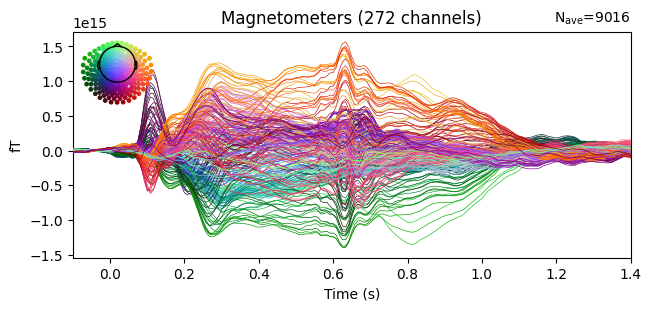

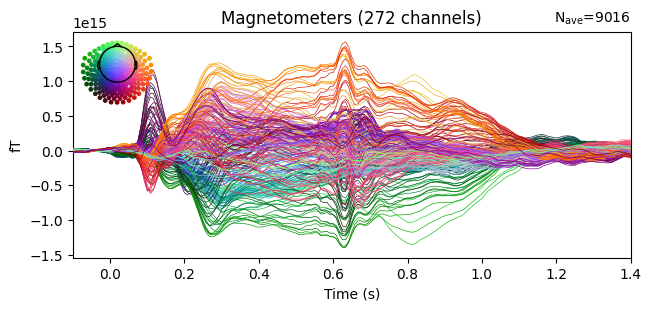

In [16]:
e.average().plot()

In [17]:
gc.collect()

9901

In [18]:
def stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, info, instance):
    i = 1
    for epochs in session_epochs:
        epochs.info['dev_head_t'] = info
        print(f"epoch_{i} done")
        i+=1
    all_epochs = mne.concatenate_epochs(epochs_list = session_epochs, add_offset=True)
    print("concatenated")
    # :9016, 9016: 18032, 18032:
    all_epochs.metadata = pd.read_csv(f'{sourcedata_dir}/sample_attributes_P{str(participant)}.csv').iloc[9016:18032,] ### change this
    print("metadata read")
    # all_epochs.resample(sfreq=output_resolution)
    all_epochs.decimate(decim=(1200/output_resolution))
    print("downsampled")
    all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)
    print("saved")
    print(all_epochs.info)
    return all_epochs

In [19]:
session_epochs = []

for session in range(5, 9):
    gc.collect()
    epoch = run_preprocessing(meg_dir,session,participant)
    session_epochs.append(epoch)
    print(f"______session_{session} done_______")

stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, session_info, "1")
print("Script Done")

ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.79   77.33    0.00 mm <->   -0.79   77.33    0.00 mm (orig :  -40.40   68.22 -237.60 mm) diff =    0.000 mm
       0.79  -77.33    0.00 mm <->    0.79  -77.33    0.00 mm (orig :   70.70  -39.37 -236.82 mm) diff =    0.000 mm
      79.52    0.00    0.00 mm <->   79.52    0.00   -0.00 mm (orig :   70.97   70.93 -233.36 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-01_meg.ds/sub-BIGMEG1_ses-05_task-main_run-01_meg.meg4: 
    System clock channel is available, checki

228 events found on stim channel UPPT001
Event IDs: [ 32  64 128]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 39601 samples (33.001 s)



/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.80   77.33    0.00 mm <->   -0.80   77.33    0.00 mm (orig :  -40.42   68.25 -237.63 mm) diff =    0.000 mm
       0.80  -77.33    0.00 mm <->    0.80  -77.33    0.00 mm (orig :   70.66  -39.35 -236.84 mm) diff =    0.000 mm
      79.53    0.00    0.00 mm <->   79.53    0.00    0.00 mm (orig :   70.96   70.95 -233.42 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.77   77.34    0.00 mm <->   -0.77   77.34    0.00 mm (orig :  -40.42   68.25 -237.72 mm) diff =    0.000 mm
       0.77  -77.34    0.00 mm <->    0.77  -77.34    0.00 mm (orig :   70.68  -39.37 -236.88 mm) diff =    0.000 mm
      79.49    0.00    0.00 mm <->   79.49   -0.00    0.00 mm (orig :   70.92   70.93 -233.47 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.72   77.33    0.00 mm <->   -0.72   77.32    0.00 mm (orig :  -40.38   68.19 -237.78 mm) diff =    0.000 mm
       0.72  -77.33    0.00 mm <->    0.72  -77.32    0.00 mm (orig :   70.71  -39.40 -236.87 mm) diff =    0.000 mm
      79.50    0.00    0.00 mm <->   79.50    0.00    0.00 mm (orig :   70.92   70.94 -233.56 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.69   77.35    0.00 mm <->   -0.69   77.35    0.00 mm (orig :  -40.51   68.13 -238.02 mm) diff =    0.000 mm
       0.69  -77.35    0.00 mm <->    0.69  -77.35   -0.00 mm (orig :   70.72  -39.40 -237.34 mm) diff =    0.000 mm
      79.52    0.00    0.00 mm <->   79.52    0.00   -0.00 mm (orig :   70.81   70.98 -233.71 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.74   77.34    0.00 mm <->   -0.74   77.34   -0.00 mm (orig :  -40.47   68.09 -238.08 mm) diff =    0.000 mm
       0.74  -77.34    0.00 mm <->    0.74  -77.34   -0.00 mm (orig :   70.71  -39.46 -237.39 mm) diff =    0.000 mm
      79.49    0.00    0.00 mm <->   79.49    0.00    0.00 mm (orig :   70.85   70.85 -233.69 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.76   77.38    0.00 mm <->   -0.76   77.38    0.00 mm (orig :  -40.50   68.14 -238.16 mm) diff =    0.000 mm
       0.76  -77.38    0.00 mm <->    0.76  -77.38    0.00 mm (orig :   70.71  -39.48 -237.40 mm) diff =    0.000 mm
      79.50    0.00    0.00 mm <->   79.50   -0.00    0.00 mm (orig :   70.87   70.86 -233.89 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.74   77.37    0.00 mm <->   -0.74   77.37    0.00 mm (orig :  -40.40   68.25 -238.03 mm) diff =    0.000 mm
       0.74  -77.37    0.00 mm <->    0.74  -77.37    0.00 mm (orig :   70.68  -39.47 -237.37 mm) diff =    0.000 mm
      79.43    0.00    0.00 mm <->   79.43    0.00    0.00 mm (orig :   70.90   70.83 -233.85 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.67   77.40    0.00 mm <->   -0.67   77.40    0.00 mm (orig :  -40.40   68.29 -238.03 mm) diff =    0.000 mm
       0.67  -77.40    0.00 mm <->    0.67  -77.40    0.00 mm (orig :   70.72  -39.49 -237.47 mm) diff =    0.000 mm
      79.55    0.00    0.00 mm <->   79.55    0.00    0.00 mm (orig :   70.97   70.96 -234.08 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-05/meg/sub-BIGMEG1_ses-05_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.67   77.41    0.00 mm <->   -0.67   77.41    0.00 mm (orig :  -40.41   68.28 -238.08 mm) diff =    0.000 mm
       0.67  -77.41    0.00 mm <->    0.67  -77.41    0.00 mm (orig :   70.74  -39.50 -237.43 mm) diff =    0.000 mm
      79.52    0.00    0.00 mm <->   79.52   -0.00   -0.00 mm (orig :   70.95   70.94 -234.03 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-25 12:14:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.85   77.48    0.00 mm <->   -0.85   77.48   -0.00 mm (orig :  -40.97   68.52 -237.41 mm) diff =    0.000 mm
       0.85  -77.48    0.00 mm <->    0.85  -77.48   -0.00 mm (orig :   70.94  -38.67 -237.41 mm) diff =    0.000 mm
      79.45    0.00    0.00 mm <->   79.45    0.00    0.00 mm (orig :   70.50   71.63 -233.42 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.72   77.49    0.00 mm <->   -0.72   77.49    0.00 mm (orig :  -40.95   68.49 -237.42 mm) diff =    0.000 mm
       0.72  -77.49    0.00 mm <->    0.72  -77.49    0.00 mm (orig :   70.96  -38.75 -237.39 mm) diff =    0.000 mm
      79.44    0.00    0.00 mm <->   79.44    0.00    0.00 mm (orig :   70.44   71.65 -233.54 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.74   77.54    0.00 mm <->   -0.74   77.54   -0.00 mm (orig :  -40.95   68.50 -237.46 mm) diff =    0.000 mm
       0.74  -77.54    0.00 mm <->    0.74  -77.54   -0.00 mm (orig :   71.01  -38.82 -237.39 mm) diff =    0.000 mm
      79.40    0.00    0.00 mm <->   79.40    0.00   -0.00 mm (orig :   70.45   71.57 -233.55 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.82   77.53    0.00 mm <->   -0.82   77.53    0.00 mm (orig :  -40.99   68.48 -237.91 mm) diff =    0.000 mm
       0.82  -77.53    0.00 mm <->    0.82  -77.53    0.00 mm (orig :   70.98  -38.81 -237.58 mm) diff =    0.000 mm
      79.49    0.00    0.00 mm <->   79.49   -0.00    0.00 mm (orig :   70.53   71.59 -233.98 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.49   77.57    0.00 mm <->   -0.49   77.57   -0.00 mm (orig :  -40.98   68.51 -237.63 mm) diff =    0.000 mm
       0.49  -77.57    0.00 mm <->    0.49  -77.57    0.00 mm (orig :   70.89  -38.99 -237.91 mm) diff =    0.000 mm
      79.59    0.00    0.00 mm <->   79.59   -0.00    0.00 mm (orig :   70.43   71.75 -234.50 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.36   77.55    0.00 mm <->   -0.36   77.55    0.00 mm (orig :  -40.97   68.53 -237.70 mm) diff =    0.000 mm
       0.36  -77.55    0.00 mm <->    0.36  -77.55    0.00 mm (orig :   70.83  -38.96 -238.39 mm) diff =    0.000 mm
      79.56    0.00    0.00 mm <->   79.56    0.00    0.00 mm (orig :   70.30   71.82 -234.74 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.38   77.42    0.00 mm <->   -0.38   77.42    0.00 mm (orig :  -40.67   68.40 -237.43 mm) diff =    0.000 mm
       0.38  -77.42    0.00 mm <->    0.38  -77.42   -0.00 mm (orig :   70.95  -38.92 -237.92 mm) diff =    0.000 mm
      79.51    0.00    0.00 mm <->   79.51   -0.00    0.00 mm (orig :   70.47   71.72 -233.98 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.44   77.45    0.00 mm <->   -0.44   77.45   -0.00 mm (orig :  -40.73   68.52 -237.43 mm) diff =    0.000 mm
       0.44  -77.45    0.00 mm <->    0.44  -77.45   -0.00 mm (orig :   70.93  -38.86 -237.94 mm) diff =    0.000 mm
      79.48    0.00    0.00 mm <->   79.48   -0.00   -0.00 mm (orig :   70.46   71.73 -233.82 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-06/meg/sub-BIGMEG1_ses-06_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.36   77.47    0.00 mm <->   -0.36   77.47   -0.00 mm (orig :  -40.73   68.49 -237.50 mm) diff =    0.000 mm
       0.36  -77.47    0.00 mm <->    0.36  -77.47    0.00 mm (orig :   70.96  -38.90 -237.97 mm) diff =    0.000 mm
      79.46    0.00    0.00 mm <->   79.46    0.00    0.00 mm (orig :   70.40   71.74 -233.93 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-27 12:42:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.72   77.46    0.00 mm <->   -0.72   77.46   -0.00 mm (orig :  -40.35   68.58 -237.40 mm) diff =    0.000 mm
       0.72  -77.46    0.00 mm <->    0.72  -77.46    0.00 mm (orig :   70.67  -39.47 -236.92 mm) diff =    0.000 mm
      79.65    0.00    0.00 mm <->   79.65   -0.00   -0.00 mm (orig :   71.12   71.01 -232.04 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.76   77.47    0.00 mm <->   -0.76   77.47   -0.00 mm (orig :  -40.37   68.63 -237.27 mm) diff =    0.000 mm
       0.76  -77.47    0.00 mm <->    0.76  -77.47   -0.00 mm (orig :   70.64  -39.46 -237.02 mm) diff =    0.000 mm
      79.60    0.00    0.00 mm <->   79.60   -0.00    0.00 mm (orig :   71.10   70.96 -232.09 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.69   77.44    0.00 mm <->   -0.69   77.44   -0.00 mm (orig :  -40.32   68.57 -237.31 mm) diff =    0.000 mm
       0.69  -77.44    0.00 mm <->    0.69  -77.44    0.00 mm (orig :   70.65  -39.48 -237.08 mm) diff =    0.000 mm
      79.56    0.00    0.00 mm <->   79.56    0.00    0.00 mm (orig :   71.05   70.94 -232.16 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.71   77.45    0.00 mm <->   -0.71   77.45    0.00 mm (orig :  -40.37   68.49 -237.51 mm) diff =    0.000 mm
       0.71  -77.45    0.00 mm <->    0.71  -77.45    0.00 mm (orig :   70.61  -39.58 -237.17 mm) diff =    0.000 mm
      79.64    0.00    0.00 mm <->   79.64    0.00    0.00 mm (orig :   71.09   70.91 -232.67 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.69   77.45    0.00 mm <->   -0.69   77.45    0.00 mm (orig :  -40.38   68.52 -237.57 mm) diff =    0.000 mm
       0.69  -77.45    0.00 mm <->    0.69  -77.45    0.00 mm (orig :   70.61  -39.55 -237.29 mm) diff =    0.000 mm
      79.65    0.00    0.00 mm <->   79.65    0.00   -0.00 mm (orig :   71.08   70.97 -232.77 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.61   77.47    0.00 mm <->   -0.61   77.47   -0.00 mm (orig :  -40.38   68.48 -237.65 mm) diff =    0.000 mm
       0.61  -77.47    0.00 mm <->    0.61  -77.47   -0.00 mm (orig :   70.64  -39.59 -237.39 mm) diff =    0.000 mm
      79.68    0.00    0.00 mm <->   79.68   -0.00    0.00 mm (orig :   71.06   71.01 -232.98 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.51   77.42    0.00 mm <->   -0.51   77.42    0.00 mm (orig :  -40.35   68.47 -237.58 mm) diff =    0.000 mm
       0.51  -77.42    0.00 mm <->    0.51  -77.42    0.00 mm (orig :   70.68  -39.47 -237.22 mm) diff =    0.000 mm
      79.63    0.00    0.00 mm <->   79.63   -0.00    0.00 mm (orig :   70.95   71.15 -232.93 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.8s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.61   77.43    0.00 mm <->   -0.61   77.43    0.00 mm (orig :  -40.41   68.39 -237.93 mm) diff =    0.000 mm
       0.61  -77.43    0.00 mm <->    0.61  -77.43    0.00 mm (orig :   70.71  -39.49 -237.35 mm) diff =    0.000 mm
      79.71    0.00    0.00 mm <->   79.71   -0.00   -0.00 mm (orig :   71.02   71.13 -233.27 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.6s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-07/meg/sub-BIGMEG1_ses-07_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.73   77.47    0.00 mm <->   -0.73   77.47   -0.00 mm (orig :  -40.52   68.37 -238.15 mm) diff =    0.000 mm
       0.73  -77.47    0.00 mm <->    0.73  -77.47   -0.00 mm (orig :   70.64  -39.56 -237.41 mm) diff =    0.000 mm
      79.81    0.00    0.00 mm <->   79.81    0.00    0.00 mm (orig :   71.10   71.07 -233.61 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-28 12:15:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.11   77.53    0.00 mm <->    0.11   77.53    0.00 mm (orig :  -40.31   68.43 -237.89 mm) diff =    0.000 mm
      -0.11  -77.53    0.00 mm <->   -0.11  -77.53    0.00 mm (orig :   70.72  -39.80 -237.68 mm) diff =    0.000 mm
      78.29    0.00    0.00 mm <->   78.29    0.00   -0.00 mm (orig :   69.74   70.42 -235.27 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.23   77.51    0.00 mm <->    0.23   77.51   -0.00 mm (orig :  -40.32   68.54 -238.03 mm) diff =    0.000 mm
      -0.23  -77.51    0.00 mm <->   -0.23  -77.51   -0.00 mm (orig :   70.68  -39.69 -237.77 mm) diff =    0.000 mm
      78.33    0.00    0.00 mm <->   78.33   -0.00    0.00 mm (orig :   69.66   70.64 -235.45 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.26   77.51    0.00 mm <->    0.26   77.51    0.00 mm (orig :  -40.33   68.59 -238.16 mm) diff =    0.000 mm
      -0.26  -77.51    0.00 mm <->   -0.26  -77.51    0.00 mm (orig :   70.69  -39.61 -237.88 mm) diff =    0.000 mm
      78.23    0.00    0.00 mm <->   78.23   -0.00    0.00 mm (orig :   69.57   70.68 -235.70 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.05   77.57    0.00 mm <->    0.05   77.57    0.00 mm (orig :  -40.34   68.60 -238.28 mm) diff =    0.000 mm
      -0.05  -77.57    0.00 mm <->   -0.05  -77.57    0.00 mm (orig :   70.77  -39.68 -237.88 mm) diff =    0.000 mm
      78.19    0.00    0.00 mm <->   78.19    0.00    0.00 mm (orig :   69.72   70.47 -235.84 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.06   77.57    0.00 mm <->    0.06   77.57    0.00 mm (orig :  -40.34   68.58 -238.22 mm) diff =    0.000 mm
      -0.06  -77.57    0.00 mm <->   -0.06  -77.57   -0.00 mm (orig :   70.78  -39.66 -237.91 mm) diff =    0.000 mm
      78.28    0.00    0.00 mm <->   78.28    0.00    0.00 mm (orig :   69.77   70.56 -235.84 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.08   77.60    0.00 mm <->    0.08   77.60    0.00 mm (orig :  -40.36   68.62 -238.38 mm) diff =    0.000 mm
      -0.08  -77.60    0.00 mm <->   -0.08  -77.60    0.00 mm (orig :   70.83  -39.66 -238.07 mm) diff =    0.000 mm
      78.13    0.00    0.00 mm <->   78.13    0.00    0.00 mm (orig :   69.67   70.49 -236.20 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.06   77.67    0.00 mm <->   -0.06   77.67   -0.00 mm (orig :  -40.40   68.62 -238.57 mm) diff =    0.000 mm
       0.06  -77.67    0.00 mm <->    0.06  -77.67   -0.00 mm (orig :   70.87  -39.78 -238.22 mm) diff =    0.000 mm
      78.02    0.00    0.00 mm <->   78.02   -0.00    0.00 mm (orig :   69.71   70.25 -236.67 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.08   77.63    0.00 mm <->   -0.08   77.63    0.00 mm (orig :  -40.30   68.61 -238.43 mm) diff =    0.000 mm
       0.08  -77.63    0.00 mm <->    0.08  -77.63    0.00 mm (orig :   70.88  -39.77 -238.25 mm) diff =    0.000 mm
      78.08    0.00    0.00 mm <->   78.08   -0.00    0.00 mm (orig :   69.84   70.26 -236.50 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-08/meg/sub-BIGMEG1_ses-08_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.02   77.63    0.00 mm <->    0.02   77.63   -0.00 mm (orig :  -40.31   68.62 -238.78 mm) diff =    0.000 mm
      -0.02  -77.63    0.00 mm <->   -0.02  -77.63    0.00 mm (orig :   70.89  -39.74 -238.37 mm) diff =    0.000 mm
      78.00    0.00    0.00 mm <->   78.00    0.00    0.00 mm (orig :   69.70   70.31 -237.03 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-03 12:18:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/4254515248.py:15: RuntimeWarning: This filename (/scratch/mr7149/net2neuro/THINGSmeg/ds004212//derivatives/preprocessed/new//preprocessed_P1-epo-1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)


Overwriting existing file.
saved
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-06-25 12:14:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 120.0 Hz
 subject_info: 1 item (dict)
>
Script Done


In [20]:
gc.collect()

11754

In [21]:
def stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, info, instance):
    i = 1
    for epochs in session_epochs:
        epochs.info['dev_head_t'] = info
        print(f"epoch_{i} done")
        i+=1
    all_epochs = mne.concatenate_epochs(epochs_list = session_epochs, add_offset=True)
    print("concatenated")
    # :9016, 9016: 18032, 18032:
    all_epochs.metadata = pd.read_csv(f'{sourcedata_dir}/sample_attributes_P{str(participant)}.csv').iloc[18032:,] ### change this
    print("metadata read")
    # all_epochs.resample(sfreq=output_resolution)
    all_epochs.decimate(decim=(1200/output_resolution))
    print("downsampled")
    all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)
    print("saved")
    print(all_epochs.info)
    return all_epochs

In [22]:
session_epochs = []

for session in range(9, 13):
    gc.collect()
    epoch = run_preprocessing(meg_dir,session,participant)
    session_epochs.append(epoch)
    print(f"______session_{session} done_______")

stack_sessions(sourcedata_dir,preproc_dir,participant,session_epochs,output_resolution, session_info, "2")
print("Script Done")

ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.02   77.69    0.00 mm <->   -0.02   77.69    0.00 mm (orig :  -40.75   68.70 -237.87 mm) diff =    0.000 mm
       0.02  -77.69    0.00 mm <->    0.02  -77.69    0.00 mm (orig :   70.67  -39.60 -237.90 mm) diff =    0.000 mm
      77.83    0.00    0.00 mm <->   77.83    0.00    0.00 mm (orig :   69.19   70.30 -234.95 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-01_meg.ds/sub-BIGMEG1_ses-09_task-main_run-01_meg.meg4: 
    System clock channel is available, checki

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.23   77.62    0.00 mm <->   -0.23   77.62    0.00 mm (orig :  -40.56   68.61 -238.09 mm) diff =    0.000 mm
       0.23  -77.62    0.00 mm <->    0.23  -77.62    0.00 mm (orig :   70.71  -39.63 -237.91 mm) diff =    0.000 mm
      77.79    0.00    0.00 mm <->   77.79   -0.00    0.00 mm (orig :   69.44   70.06 -235.09 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.33   77.59    0.00 mm <->   -0.33   77.59   -0.00 mm (orig :  -40.52   68.58 -238.36 mm) diff =    0.000 mm
       0.33  -77.59    0.00 mm <->    0.33  -77.59    0.00 mm (orig :   70.71  -39.63 -237.93 mm) diff =    0.000 mm
      77.69    0.00    0.00 mm <->   77.69    0.00    0.00 mm (orig :   69.47   69.89 -235.36 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.27   77.77    0.00 mm <->   -0.27   77.77   -0.00 mm (orig :  -40.79   68.82 -238.96 mm) diff =    0.000 mm
       0.27  -77.77    0.00 mm <->    0.27  -77.77   -0.00 mm (orig :   70.75  -39.59 -238.30 mm) diff =    0.000 mm
      77.58    0.00    0.00 mm <->   77.58   -0.00    0.00 mm (orig :   69.22   70.05 -236.71 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.38   77.75    0.00 mm <->   -0.38   77.75   -0.00 mm (orig :  -40.70   68.83 -238.96 mm) diff =    0.000 mm
       0.38  -77.75    0.00 mm <->    0.38  -77.75   -0.00 mm (orig :   70.77  -39.58 -238.26 mm) diff =    0.000 mm
      77.61    0.00    0.00 mm <->   77.61    0.00    0.00 mm (orig :   69.39   69.98 -236.83 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.11   77.83    0.00 mm <->   -0.11   77.83    0.00 mm (orig :  -40.87   68.94 -238.86 mm) diff =    0.000 mm
       0.11  -77.83    0.00 mm <->    0.11  -77.83   -0.00 mm (orig :   70.76  -39.54 -238.28 mm) diff =    0.000 mm
      77.51    0.00    0.00 mm <->   77.51   -0.00   -0.00 mm (orig :   69.02   70.20 -236.81 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.07   77.83    0.00 mm <->   -0.07   77.83    0.00 mm (orig :  -40.86   68.96 -238.74 mm) diff =    0.000 mm
       0.07  -77.83    0.00 mm <->    0.07  -77.83    0.00 mm (orig :   70.78  -39.51 -238.29 mm) diff =    0.000 mm
      77.53    0.00    0.00 mm <->   77.53   -0.00   -0.00 mm (orig :   69.02   70.27 -236.81 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.10   77.82    0.00 mm <->   -0.10   77.82   -0.00 mm (orig :  -40.86   68.93 -238.77 mm) diff =    0.000 mm
       0.10  -77.82    0.00 mm <->    0.10  -77.82   -0.00 mm (orig :   70.79  -39.51 -238.31 mm) diff =    0.000 mm
      77.45    0.00    0.00 mm <->   77.45    0.00    0.00 mm (orig :   68.98   70.18 -236.91 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.18   77.79    0.00 mm <->   -0.18   77.79    0.00 mm (orig :  -40.81   68.89 -238.82 mm) diff =    0.000 mm
       0.18  -77.79    0.00 mm <->    0.18  -77.79    0.00 mm (orig :   70.79  -39.52 -238.32 mm) diff =    0.000 mm
      77.39    0.00    0.00 mm <->   77.39    0.00   -0.00 mm (orig :   69.02   70.07 -236.98 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-09/meg/sub-BIGMEG1_ses-09_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.18   77.84    0.00 mm <->   -0.18   77.84    0.00 mm (orig :  -40.86   68.98 -238.84 mm) diff =    0.000 mm
       0.18  -77.84    0.00 mm <->    0.18  -77.84    0.00 mm (orig :   70.81  -39.47 -238.34 mm) diff =    0.000 mm
      77.51    0.00    0.00 mm <->   77.51    0.00    0.00 mm (orig :   69.09   70.22 -236.97 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-08 12:22:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.51   77.20    0.00 mm <->   -0.51   77.20    0.00 mm (orig :  -40.56   68.32 -237.85 mm) diff =    0.000 mm
       0.51  -77.20    0.00 mm <->    0.51  -77.20    0.00 mm (orig :   70.49  -38.96 -237.72 mm) diff =    0.000 mm
      78.32    0.00    0.00 mm <->   78.32   -0.00    0.00 mm (orig :   69.67   70.57 -233.60 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.5s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.34   77.19    0.00 mm <->   -0.34   77.19    0.00 mm (orig :  -40.61   68.37 -238.05 mm) diff =    0.000 mm
       0.34  -77.19    0.00 mm <->    0.34  -77.19    0.00 mm (orig :   70.53  -38.77 -238.02 mm) diff =    0.000 mm
      78.25    0.00    0.00 mm <->   78.25    0.00    0.00 mm (orig :   69.45   70.83 -234.32 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.40   77.22    0.00 mm <->   -0.40   77.22   -0.00 mm (orig :  -40.59   68.32 -238.03 mm) diff =    0.000 mm
       0.40  -77.22    0.00 mm <->    0.40  -77.22   -0.00 mm (orig :   70.58  -38.90 -238.04 mm) diff =    0.000 mm
      78.21    0.00    0.00 mm <->   78.21    0.00    0.00 mm (orig :   69.51   70.66 -234.34 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.24   77.24    0.00 mm <->   -0.25   77.24    0.00 mm (orig :  -40.40   68.42 -238.29 mm) diff =    0.000 mm
       0.24  -77.24    0.00 mm <->    0.24  -77.24   -0.00 mm (orig :   70.75  -38.86 -238.19 mm) diff =    0.000 mm
      78.04    0.00    0.00 mm <->   78.04    0.00    0.00 mm (orig :   69.51   70.73 -235.41 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.7s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.22   77.22    0.00 mm <->   -0.22   77.22    0.00 mm (orig :  -40.33   68.43 -238.34 mm) diff =    0.000 mm
       0.22  -77.22    0.00 mm <->    0.22  -77.22    0.00 mm (orig :   70.80  -38.83 -238.17 mm) diff =    0.000 mm
      78.04    0.00    0.00 mm <->   78.04    0.00    0.00 mm (orig :   69.54   70.76 -235.36 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.5s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -0.03   77.32    0.00 mm <->   -0.03   77.32    0.00 mm (orig :  -40.73   68.53 -238.35 mm) diff =    0.000 mm
       0.03  -77.32    0.00 mm <->    0.03  -77.32    0.00 mm (orig :   70.32  -39.08 -238.97 mm) diff =    0.000 mm
      78.12    0.00    0.00 mm <->   78.12   -0.00    0.00 mm (orig :   69.14   70.75 -235.39 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.6s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.01   77.39    0.00 mm <->    0.01   77.39   -0.00 mm (orig :  -40.76   68.45 -238.86 mm) diff =    0.000 mm
      -0.01  -77.39    0.00 mm <->   -0.01  -77.39   -0.00 mm (orig :   70.46  -39.20 -238.78 mm) diff =    0.000 mm
      78.04    0.00    0.00 mm <->   78.04   -0.00    0.00 mm (orig :   69.08   70.67 -235.78 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.5s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.02   77.40    0.00 mm <->    0.02   77.40    0.00 mm (orig :  -40.74   68.45 -238.87 mm) diff =    0.000 mm
      -0.02  -77.40    0.00 mm <->   -0.02  -77.40    0.00 mm (orig :   70.50  -39.21 -238.67 mm) diff =    0.000 mm
      78.16    0.00    0.00 mm <->   78.16   -0.00    0.00 mm (orig :   69.18   70.76 -235.75 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-10/meg/sub-BIGMEG1_ses-10_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.10   77.41    0.00 mm <->    0.10   77.41    0.00 mm (orig :  -40.71   68.46 -238.78 mm) diff =    0.000 mm
      -0.10  -77.41    0.00 mm <->   -0.10  -77.41   -0.00 mm (orig :   70.62  -39.13 -238.69 mm) diff =    0.000 mm
      78.04    0.00    0.00 mm <->   78.04    0.00    0.00 mm (orig :   69.07   70.81 -235.92 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-10 12:45:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       1.32   76.91    0.00 mm <->    1.32   76.91   -0.00 mm (orig :  -39.99   67.45 -238.34 mm) diff =    0.000 mm
      -1.32  -76.91    0.00 mm <->   -1.32  -76.91   -0.00 mm (orig :   70.77  -39.31 -238.75 mm) diff =    0.000 mm
      77.72    0.00    0.00 mm <->   77.72    0.00    0.00 mm (orig :   68.34   70.91 -236.22 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       1.38   76.95    0.00 mm <->    1.38   76.95   -0.00 mm (orig :  -40.01   67.51 -238.46 mm) diff =    0.000 mm
      -1.38  -76.95    0.00 mm <->   -1.38  -76.95    0.00 mm (orig :   70.80  -39.31 -239.11 mm) diff =    0.000 mm
      77.90    0.00    0.00 mm <->   77.90    0.00    0.00 mm (orig :   68.43   71.12 -236.74 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       1.26   76.91    0.00 mm <->    1.26   76.91   -0.00 mm (orig :  -39.84   67.54 -239.09 mm) diff =    0.000 mm
      -1.26  -76.91    0.00 mm <->   -1.26  -76.91   -0.00 mm (orig :   70.95  -39.19 -239.30 mm) diff =    0.000 mm
      77.84    0.00    0.00 mm <->   77.84   -0.00   -0.00 mm (orig :   68.63   71.10 -237.73 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.95   76.92    0.00 mm <->    0.95   76.92   -0.00 mm (orig :  -39.56   67.76 -239.59 mm) diff =    0.000 mm
      -0.95  -76.92    0.00 mm <->   -0.95  -76.92   -0.00 mm (orig :   71.09  -39.13 -239.50 mm) diff =    0.000 mm
      77.53    0.00    0.00 mm <->   77.53    0.00   -0.00 mm (orig :   68.93   70.73 -238.34 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       1.04   76.79    0.00 mm <->    1.04   76.79    0.00 mm (orig :  -39.70   67.53 -239.41 mm) diff =    0.000 mm
      -1.04  -76.79    0.00 mm <->   -1.04  -76.79    0.00 mm (orig :   70.93  -39.01 -239.17 mm) diff =    0.000 mm
      77.65    0.00    0.00 mm <->   77.65   -0.00    0.00 mm (orig :   68.70   70.91 -238.11 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       1.03   76.81    0.00 mm <->    1.03   76.81    0.00 mm (orig :  -39.78   67.60 -239.41 mm) diff =    0.000 mm
      -1.03  -76.81    0.00 mm <->   -1.03  -76.81    0.00 mm (orig :   70.93  -38.93 -239.39 mm) diff =    0.000 mm
      77.84    0.00    0.00 mm <->   77.84   -0.00    0.00 mm (orig :   68.79   71.14 -238.43 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.5s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.98   76.79    0.00 mm <->    0.98   76.79   -0.00 mm (orig :  -39.74   67.58 -239.30 mm) diff =    0.000 mm
      -0.98  -76.79    0.00 mm <->   -0.98  -76.79    0.00 mm (orig :   70.97  -38.88 -239.16 mm) diff =    0.000 mm
      77.87    0.00    0.00 mm <->   77.87    0.00    0.00 mm (orig :   68.86   71.16 -238.39 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.99   76.80    0.00 mm <->    0.99   76.80    0.00 mm (orig :  -39.76   67.61 -239.33 mm) diff =    0.000 mm
      -0.99  -76.80    0.00 mm <->   -0.99  -76.80    0.00 mm (orig :   70.97  -38.84 -239.23 mm) diff =    0.000 mm
      77.88    0.00    0.00 mm <->   77.88   -0.00    0.00 mm (orig :   68.85   71.21 -238.44 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-11/meg/sub-BIGMEG1_ses-11_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.91   76.82    0.00 mm <->    0.91   76.82   -0.00 mm (orig :  -39.79   67.65 -239.36 mm) diff =    0.000 mm
      -0.91  -76.82    0.00 mm <->   -0.91  -76.82    0.00 mm (orig :   70.99  -38.81 -239.21 mm) diff =    0.000 mm
      77.81    0.00    0.00 mm <->   77.81   -0.00   -0.00 mm (orig :   68.84   71.15 -238.27 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-11 12:28:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.9s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-02_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.23   77.48    0.00 mm <->    0.23   77.48   -0.00 mm (orig :  -40.42   68.60 -238.10 mm) diff =    0.000 mm
      -0.23  -77.48    0.00 mm <->   -0.23  -77.48   -0.00 mm (orig :   70.77  -39.35 -238.07 mm) diff =    0.000 mm
      76.63    0.00    0.00 mm <->   76.63   -0.00    0.00 mm (orig :   68.38   69.75 -236.31 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coord

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
452 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-03_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.59   77.76    0.00 mm <->    0.59   77.76    0.00 mm (orig :  -41.17   68.57 -239.82 mm) diff =    0.000 mm
      -0.59  -77.76    0.00 mm <->   -0.59  -77.76   -0.00 mm (orig :   70.70  -39.46 -239.86 mm) diff =    0.000 mm
      76.56    0.00    0.00 mm <->   76.56    0.00    0.00 mm (orig :   67.51   70.02 -238.17 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.4s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
678 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-04_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.21   77.67    0.00 mm <->    0.21   77.67    0.00 mm (orig :  -41.07   68.67 -242.25 mm) diff =    0.000 mm
      -0.21  -77.67    0.00 mm <->   -0.21  -77.67    0.00 mm (orig :   70.35  -39.56 -239.91 mm) diff =    0.000 mm
      76.74    0.00    0.00 mm <->   76.74   -0.00    0.00 mm (orig :   67.88   69.73 -237.93 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.3s


Not setting metadata
226 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
904 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-05_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.48   77.77    0.00 mm <->    0.48   77.77   -0.00 mm (orig :  -41.00   68.76 -239.39 mm) diff =    0.000 mm
      -0.48  -77.77    0.00 mm <->   -0.48  -77.77   -0.00 mm (orig :   70.58  -39.59 -239.26 mm) diff =    0.000 mm
      76.61    0.00    0.00 mm <->   76.61   -0.00    0.00 mm (orig :   67.81   69.86 -237.62 mm) diff =    0.000 mm
    Coordinate transfo

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1129 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-06_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.50   77.51    0.00 mm <->    0.50   77.51   -0.00 mm (orig :  -40.46   68.68 -238.71 mm) diff =    0.000 mm
      -0.50  -77.51    0.00 mm <->   -0.50  -77.51   -0.00 mm (orig :   70.62  -39.44 -238.14 mm) diff =    0.000 mm
      76.84    0.00    0.00 mm <->   76.84   -0.00    0.00 mm (orig :   68.30   70.02 -236.68 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.0s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1354 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-07_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.46   77.50    0.00 mm <->    0.46   77.50    0.00 mm (orig :  -40.42   68.73 -238.72 mm) diff =    0.000 mm
      -0.46  -77.50    0.00 mm <->   -0.46  -77.50   -0.00 mm (orig :   70.62  -39.42 -238.17 mm) diff =    0.000 mm
      76.90    0.00    0.00 mm <->   76.90   -0.00    0.00 mm (orig :   68.41   70.05 -236.68 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.1s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1579 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-08_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.44   77.52    0.00 mm <->    0.44   77.52    0.00 mm (orig :  -40.45   68.76 -238.72 mm) diff =    0.000 mm
      -0.44  -77.52    0.00 mm <->   -0.44  -77.52    0.00 mm (orig :   70.62  -39.42 -238.18 mm) diff =    0.000 mm
      76.83    0.00    0.00 mm <->   76.83    0.00    0.00 mm (orig :   68.36   70.01 -236.74 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
1804 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-09_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.41   77.53    0.00 mm <->    0.41   77.53    0.00 mm (orig :  -40.38   68.73 -238.92 mm) diff =    0.000 mm
      -0.41  -77.53    0.00 mm <->   -0.41  -77.53    0.00 mm (orig :   70.70  -39.45 -238.37 mm) diff =    0.000 mm
      76.77    0.00    0.00 mm <->   76.77   -0.00    0.00 mm (orig :   68.42   69.91 -237.16 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2029 matching events found
No baseline correction applied
ds directory : /scratch/mr7149/net2neuro/THINGSmeg/ds004212/sub-BIGMEG1/ses-12/meg/sub-BIGMEG1_ses-12_task-main_run-10_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       0.41   77.55    0.00 mm <->    0.41   77.55   -0.00 mm (orig :  -40.43   68.76 -238.74 mm) diff =    0.000 mm
      -0.41  -77.55    0.00 mm <->   -0.41  -77.55    0.00 mm (orig :   70.70  -39.44 -238.28 mm) diff =    0.000 mm
      76.78    0.00    0.00 mm <->   76.78   -0.00    0.00 mm (orig :   68.39   69.95 -236.89 mm) diff =    0.000 mm
    Coordinate transf

/state/partition1/job-54684344/ipykernel_1112486/3913805742.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  event_file.value.fillna(999999,inplace=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.2s


Not setting metadata
225 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 1801 original time points ...
0 bad epochs dropped
Not setting metadata
2254 matching events found
No baseline correction applied
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-12 12:14:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>
Applying baseline correction (mode: zscore)
Not setting metadata
2254 matching

/state/partition1/job-54684344/ipykernel_1112486/1749860479.py:15: RuntimeWarning: This filename (/scratch/mr7149/net2neuro/THINGSmeg/ds004212//derivatives/preprocessed/new//preprocessed_P1-epo-2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  all_epochs.save(f'{preproc_dir}/preprocessed_P{str(participant)}-epo-{instance}.fif', overwrite=True)


Overwriting existing file.
saved
<Info | 15 non-empty values
 bads: []
 ch_names: MLC11-1609, MLC12-1609, MLC13-1609, MLC14-1609, MLC15-1609, ...
 chs: 272 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: hebart
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2019-07-08 12:22:00 UTC
 meas_id: 4 items (dict)
 nchan: 272
 projs: []
 sfreq: 120.0 Hz
 subject_info: 1 item (dict)
>
Script Done


In [23]:
gc.collect()

11754